<a href="https://colab.research.google.com/github/AbhinavKSeth/SRE/blob/master/Attempt3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import cv2
import PIL
import copy
import time
import torch
import shutil
import random
import numpy as np
import pandas as pd
from torch import nn
from PIL import Image
import torch.optim as optim
import matplotlib.pyplot as plt
from skimage import io, transform
from torchvision import datasets
import matplotlib.image as mpimg
from torchvision import transforms
from torch.optim import lr_scheduler
import torchvision.models as models
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF

In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomAffine([-90,90]),
        transforms.Resize([300,300]),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize([300,300]),                       
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}


In [0]:
data_dir = "/content/drive/My Drive/path/data_Attempt3"
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
image_datasets['val'].class_to_idx

{'Defective': 0, 'Good': 1}

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    # if(phase == 'val'): 
                    #   print(labels)
                    #   print(outputs)

                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            # print(labels)
            # print(outputs)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), "/content/drive/My Drive/path/ATTEMPT_2.pth")
    return model

In [6]:
vgg19 = models.vgg19(pretrained=True)

for param in vgg19.parameters():
    param.requires_grad_(False)
vgg19.classifier = nn.Sequential(
                    nn.Linear(25088,4096,bias = True),
                    nn.ReLU(inplace=True),
                    nn.Dropout(p=0.5, inplace=False),
                    nn.Linear(4096,2048,bias = True),
                    nn.ReLU(inplace=True),
                    nn.Dropout(p=0.5, inplace=False),
                    nn.Linear(2048,2,bias = True)
                    )
vgg19  = vgg19.to(device)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth


In [0]:
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer1 = optim.SGD(vgg19.classifier.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer1, step_size=7, gamma=0.1)

In [9]:
 vgg19.load_state_dict(torch.load("/content/drive/My Drive/path/ATTEMPT_2.pth"))
 vgg19.eval()
#vgg19 = train_model(vgg19, criterion, optimizer1,
                          # exp_lr_scheduler, num_epochs=25)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [11]:
# data_dir = "/content/drive/My Drive/path/data"
# transform = transforms.Compose([transforms.Resize([300,300]),
#                                 transforms.ToTensor(),
#                                 transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
# # real_dataset = datasets.ImageFolder(data_dir,transform)
# dataloader = torch.utils.data.DataLoader(real_dataset, batch_size=4,
#                                           shuffle=True, num_workers=4)
real_dataset = image_datasets['val']
dataloader = dataloaders['val']
dataset_size =  len(real_dataset)
class_names = real_dataset.classes
print(real_dataset.class_to_idx)
print("size:",dataset_size)

{'Defective': 0, 'Good': 1}
size: 1009


In [0]:
def test_accuracy(model, criterion):
    since = time.time()

    model.eval()   # Set model to evaluate mode

    running_loss = 0.0
    running_corrects = 0

    # Iterate over data.
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        loss = criterion(outputs, labels)

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
    epoch_loss = running_loss / dataset_size
    epoch_acc = running_corrects.double() / dataset_size

    # print('test Loss: {:.4f} Acc: {:.4f}'.format(
    #       epoch_loss, epoch_acc))

    print()

    time_elapsed = time.time() - since
    print('Testing complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Test Acc: {:4f}'.format(epoch_acc))
    return

In [13]:
criterion = nn.CrossEntropyLoss()
test_accuracy(vgg19,criterion)


Testing complete in 3m 56s
Test Acc: 0.762141


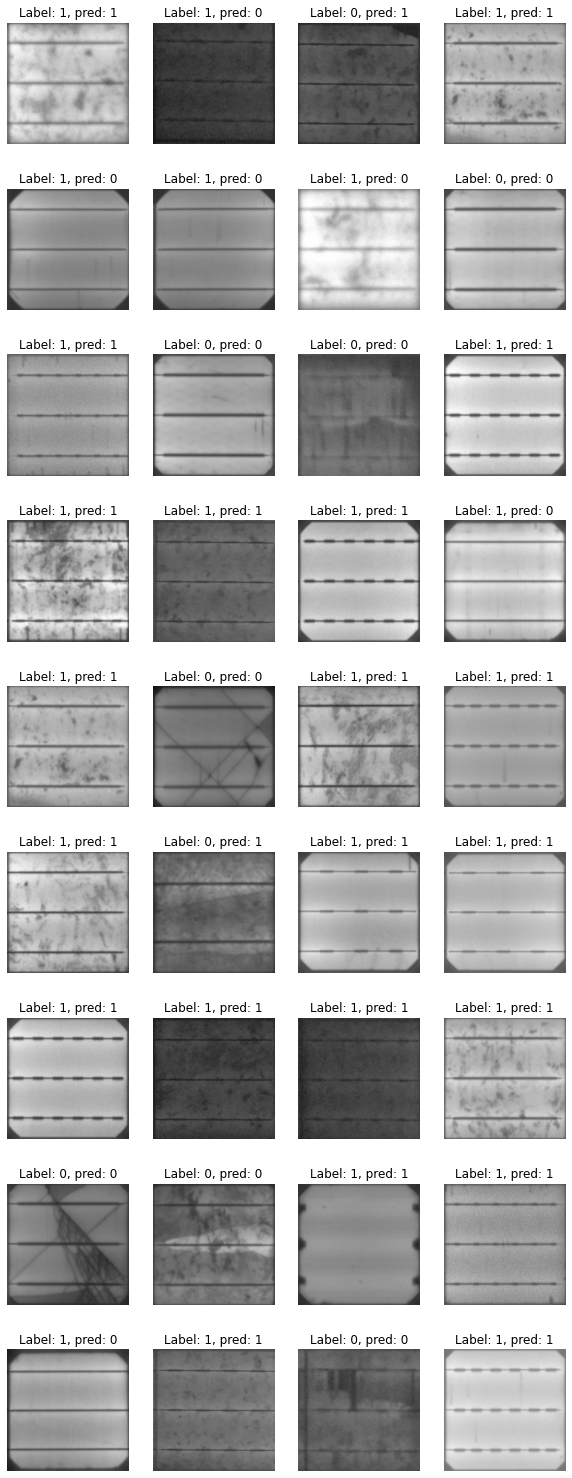

In [15]:
#converts normalised tensor input to denormalised numpy array 
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5,0.5,0.5]) #this mean array was used during normalisation
    std = np.array([0.5,0.5,0.5])  #this std array was used during normalisation
    inp = std * inp + mean # normalising formulae was: inp = (inp-mean)/std
    inp = np.clip(inp, 0, 1) # scaling the val in the range [0,1]
    plt.imshow(inp)

# for visulaisation;
vgg19.eval()  #This would change the state if model is in trian mode
              #,to eval mode. remember to change it back to its original
              # state.
 
num_images=36 #multiple of 4, the batch size and also i have chose to represent
              # 4 images in a row.
images_so_far =0              
fig = plt.figure(figsize=(10,30))
with torch.no_grad():
  for i,(inputs, labels) in enumerate(dataloader,0):
  
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = vgg19(inputs)
    _, preds = torch.max(outputs, 1)
    for j in range(4): # 4 is the batch size
      images_so_far += 1
       #4 images in a row
       # images_so_far< rows(=1+num_images//4)*cols(=4)
      ax = plt.subplot(num_images//4+1, 4, images_so_far)   
      ax.axis('off')
      ax.set_title('Label: {}, pred: {}'.format(labels[j],preds[j]))
      imshow(inputs.cpu().data[j])
    if images_so_far >= num_images:
        break